In [1]:
import sys
sys.path.append('../RecSysRep/')

In [2]:
import Basics.Load as ld

URM_all, _, _, _, _ = ld.getCOOs()
ICM_weighted = ld.getICMselected('7')
# URM_train, URM_val = ld.getSplit(URM_train_val, 5678, 0.8)

In [3]:
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8, seed=1234)
# URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_validation, train_percentage = 0.8)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
# evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 13643 ( 0.1%) Users that have less than 1 test interactions


In [4]:
import os

ofp = "../models_temp/Similarity_Hybrid/"

models_to_combine_best = {
                            'RP3ICMnew': {'alpha': 1.029719677583138, 'beta': 1.0630164752134375, 'topK': 6964, 'normalize_similarity': True},
                            'RP3ICM' : {"topK": 2550, "alpha": 1.3058102610510849, "beta": 0.5150718337969987, "normalize_similarity": True, "implicit": True},
                            'IALS' : {"num_factors": 29, "epochs": 50, "confidence_scaling": "log", "alpha": 0.001, "epsilon": 0.001, "reg": 0.01},
                            'SLIMgensub': {"l1_ratio" : 0.025887359156206147, "topK": 2140, "alpha": 0.009567288586539689, "workers": 8, "mw": 1},
                            'SLIMBPR' : {"epochs": 440, "lambda_i": 0.007773815998802306, "lambda_j": 0.003342522366982381, "learning_rate": 0.010055161410725193, "topK": 4289, "random_seed": 1234, "sgd_mode": "sgd"},
                            'SLIMweig': {'l1_ratio': 0.0005247075138160404, 'topK': 4983, 'alpha': 0.06067400905430761, 'workers': 8, 'mw': 2.308619939318322},
                            'SLIMER': {'topK': 6000, 'l1_ratio': 0.0005495104968035837, 'alpha': 0.08007142704041009, 'workers': 8},
                            'P3alpha': {'topK': 4834, 'alpha': 1.764994849187595, 'normalize_similarity': True, 'implicit': True},
                            'RP3beta': {"topK": 1049, "alpha": 1.1626473723475605, "beta": 0.6765017195261293, "normalize_similarity": True, "implicit": True},
                            'icm_weighted': {"shrink": 4000, "topK": 985, "feature_weighting": "TF-IDF", "normalize": True}
                         }


In [5]:
def model_init(recommender, name, args):
    path_name = ofp + name + ".zip"
    print(path_name)
    if os.path.exists(path_name):
        print("Model found!")
        recommender.load_model(ofp, name)
    else:
        print("Model does not exists, creating...")
        if not os.path.exists(ofp):
            print("Main folder does not exist, creating...")
            os.makedirs(ofp)
        recommender.fit(**args)
        recommender.save_model(ofp, name)

In [6]:
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommenderICM
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender

In [19]:
from Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from Recommenders.KNN.ItemKNNSimilarityHybridRecommenderNormal import ItemKNNSimilarityHybridRecommenderNormal

In [20]:
recommender1 = RP3betaRecommender(URM_train)
recommender2 = ItemKNNCBFRecommender(URM_train, ICM_weighted)

model_init(recommender1, 'RP3beta', models_to_combine_best['RP3beta'])
model_init(recommender2, 'KNNweigh', models_to_combine_best['icm_weighted'])

ItemKNNCBFRecommender: ICM Detected 22 ( 0.1%) items with no features.
../models_temp/Similarity_Hybrid/RP3beta.zip
Model found!
RP3betaRecommender: Loading model from file '../models_temp/Similarity_Hybrid/RP3beta'
RP3betaRecommender: Loading complete
../models_temp/Similarity_Hybrid/KNNweigh.zip
Model found!
ItemKNNCBFRecommender: Loading model from file '../models_temp/Similarity_Hybrid/KNNweigh'
ItemKNNCBFRecommender: Loading complete


In [21]:
def rank_models(evaluator, recommenders):
    for r in recommenders:
        r_d, _ = evaluator.evaluateRecommender(r)
        print(r.RECOMMENDER_NAME, r_d.loc[10]['MAP'])

In [22]:
rank_models(evaluator_validation, [recommender1, recommender2])

EvaluatorHoldout: Processed 13643 (100.0%) in 22.97 sec. Users per second: 594
RP3betaRecommender 0.22063505734087704
EvaluatorHoldout: Processed 13643 (100.0%) in 19.20 sec. Users per second: 711
ItemKNNCBFRecommender 0.07652628710112308


In [23]:
import matplotlib.pyplot as plt

In [29]:
import numpy as np

def test_percentage(recommender_1, recommender_2, evaluator, step):
    recommender = ItemKNNSimilarityHybridRecommenderNormal(URM_train, recommender_1.W_sparse, recommender_2.W_sparse)
    results = []
    alp_space = np.linspace(0.954, 0.9564, step, True) # Explore 0.954-0.9564 and 0.962 and 0.966 
    for alp in alp_space:
        recommender.fit(alp)
        r_d, _ = evaluator.evaluateRecommender(recommender)
        print(alp, ":", r_d.loc[10]['MAP'])
        results.append(r_d.loc[10]['MAP'])
    
    return alp_space, results

In [30]:
alp_space, results = test_percentage(recommender1, recommender2, evaluator_validation, 20)

EvaluatorHoldout: Processed 13643 (100.0%) in 22.16 sec. Users per second: 616
0.954 : 0.2236395284982478
EvaluatorHoldout: Processed 13643 (100.0%) in 20.92 sec. Users per second: 652
0.9541263157894736 : 0.2236420037486522
EvaluatorHoldout: Processed 13643 (100.0%) in 19.89 sec. Users per second: 686
0.9542526315789474 : 0.22365485701720436
EvaluatorHoldout: Processed 13643 (100.0%) in 21.41 sec. Users per second: 637
0.954378947368421 : 0.2236688591975191
EvaluatorHoldout: Processed 13643 (100.0%) in 21.23 sec. Users per second: 643
0.9545052631578947 : 0.22367088942640564
EvaluatorHoldout: Processed 13643 (100.0%) in 22.40 sec. Users per second: 609
0.9546315789473684 : 0.22367469101545237
EvaluatorHoldout: Processed 13643 (100.0%) in 20.92 sec. Users per second: 652
0.9547578947368421 : 0.22365367901906844
EvaluatorHoldout: Processed 13643 (100.0%) in 20.88 sec. Users per second: 654
0.9548842105263158 : 0.22363637262669814
EvaluatorHoldout: Processed 13643 (100.0%) in 21.51 sec. 

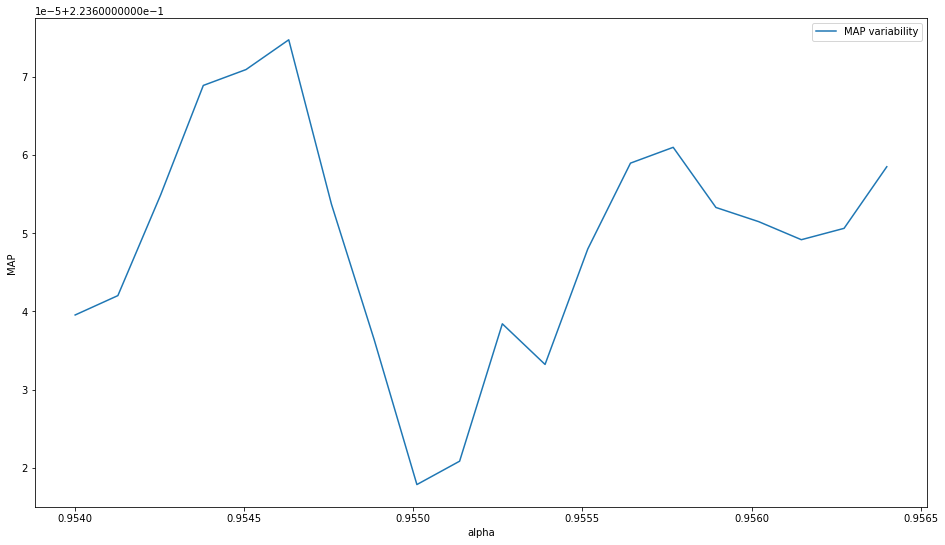

In [32]:
import matplotlib.pyplot as plt

_ = plt.figure(figsize=(16, 9))
plt.plot(alp_space, results, label='MAP variability')
plt.ylabel('MAP')
plt.xlabel('alpha')
plt.legend()
plt.show()

In [33]:
import numpy as np

def test_percentage(recommender_1, recommender_2, evaluator, high, low, step):
    recommender = ItemKNNSimilarityHybridRecommenderNormal(URM_train, recommender_1.W_sparse, recommender_2.W_sparse)
    results = []
    alp_space = np.linspace(high, low, step, True) # Explore 0.954-0.9564 and 0.962 and 0.966 
    for alp in alp_space:
        recommender.fit(alp)
        r_d, _ = evaluator.evaluateRecommender(recommender)
        print(alp, ":", r_d.loc[10]['MAP'])
        results.append(r_d.loc[10]['MAP'])
    
    return alp_space, results

In [34]:
alp_space, results = test_percentage(recommender1, recommender2, evaluator_validation, 0.9545, 0.9548, 20)

EvaluatorHoldout: Processed 13643 (100.0%) in 20.58 sec. Users per second: 663
0.9545 : 0.22366876030384852
EvaluatorHoldout: Processed 13643 (100.0%) in 20.33 sec. Users per second: 671
0.9545157894736842 : 0.22367170966214492
EvaluatorHoldout: Processed 13643 (100.0%) in 21.15 sec. Users per second: 645
0.9545315789473684 : 0.223681055114025
EvaluatorHoldout: Processed 13643 (100.0%) in 22.40 sec. Users per second: 609
0.9545473684210526 : 0.2236801796141756
EvaluatorHoldout: Processed 13643 (100.0%) in 21.47 sec. Users per second: 635
0.9545631578947369 : 0.22368371942585877
EvaluatorHoldout: Processed 13643 (100.0%) in 21.36 sec. Users per second: 639
0.9545789473684211 : 0.22368107547448657
EvaluatorHoldout: Processed 13643 (100.0%) in 20.69 sec. Users per second: 659
0.9545947368421053 : 0.2236893563650881
EvaluatorHoldout: Processed 13643 (100.0%) in 20.11 sec. Users per second: 678
0.9546105263157895 : 0.22369234062703297
EvaluatorHoldout: Processed 13643 (100.0%) in 20.18 sec.

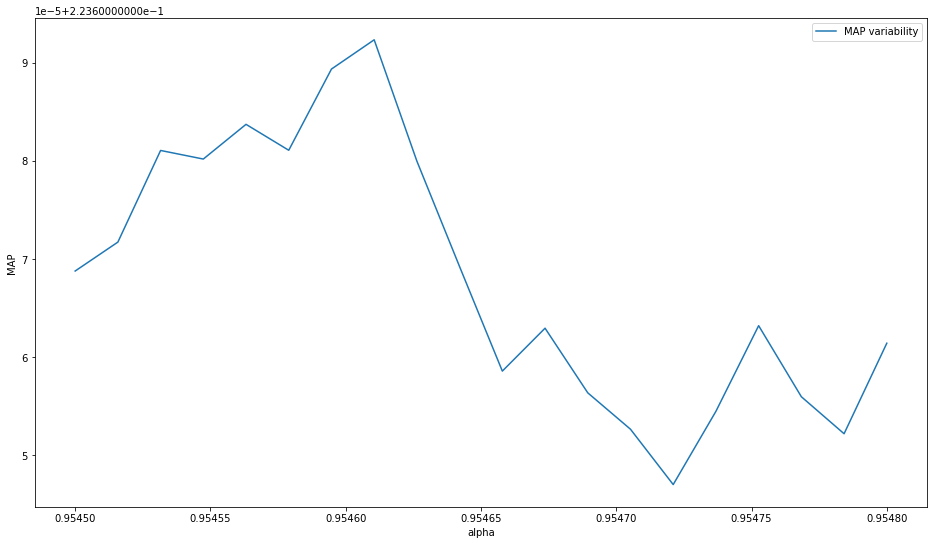

In [35]:
import matplotlib.pyplot as plt

_ = plt.figure(figsize=(16, 9))
plt.plot(alp_space, results, label='MAP variability')
plt.ylabel('MAP')
plt.xlabel('alpha')
plt.legend()
plt.show()

EvaluatorHoldout: Processed 13643 (100.0%) in 19.40 sec. Users per second: 703
0.95459 : 0.2236913109694029
EvaluatorHoldout: Processed 13643 (100.0%) in 19.28 sec. Users per second: 708
0.9545926315789475 : 0.2236901707835526
EvaluatorHoldout: Processed 13643 (100.0%) in 19.52 sec. Users per second: 699
0.9545952631578948 : 0.22369014169717885
EvaluatorHoldout: Processed 13643 (100.0%) in 19.50 sec. Users per second: 699
0.9545978947368422 : 0.22369014169717885
EvaluatorHoldout: Processed 13643 (100.0%) in 20.08 sec. Users per second: 679
0.9546005263157895 : 0.22369057799278486
EvaluatorHoldout: Processed 13643 (100.0%) in 20.91 sec. Users per second: 653
0.9546031578947369 : 0.22368952797469316
EvaluatorHoldout: Processed 13643 (100.0%) in 20.19 sec. Users per second: 676
0.9546057894736842 : 0.2236905314545869
EvaluatorHoldout: Processed 13643 (100.0%) in 20.11 sec. Users per second: 678
0.9546084210526317 : 0.22368943198965982
EvaluatorHoldout: Processed 13643 (100.0%) in 19.54 se

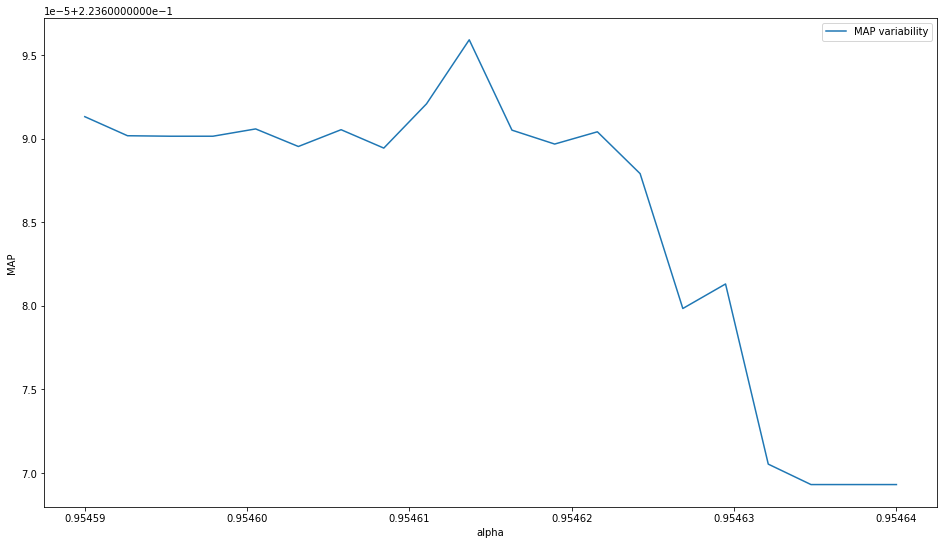

In [36]:
alp_space, results = test_percentage(recommender1, recommender2, evaluator_validation, 0.95459, 0.95464, 20)

import matplotlib.pyplot as plt

_ = plt.figure(figsize=(16, 9))
plt.plot(alp_space, results, label='MAP variability')
plt.ylabel('MAP')
plt.xlabel('alpha')
plt.legend()
plt.show()